
# Handwritten Digit Recognition - Deep Neural Networks
## Notebook by <a href="https://github.com/agnivahp"><u>Agnivah Poddar</u></a>
### University of Illinois - Urbana Champaign
---

## Table of Contents
1. <a href='#Intro'>Introduction</a>
2. <a href='#License'>License</a>
3. <a href='#Req'>Required Libraries</a>
4. Problem domain
5. Step 1
5. Step 2
5. Step 3
5. Step 4
6. Conclusions
7. References
8. Acknowledgements

---

<a id='Intro'></a>
## Introduction
In this notebook, we will progressively build and improve a neural network that recognizes hand-written digits all the way to 99% accuracy. 

As we build and train the network, we will discover the tools that are used to model deep neural networks efficiently and learn about some tricks that can be used to improve the performance. 
We will be using the famous MNIST dataset which consists of 60,000 labeled handwritten digits. We will start with a simple one layer network and add more layers to go on to build a more complex 5 layered convolutional network.

---

<a id='License'></a>
## License

---

<a id='Req'></a>
## Required Libraries
We will need the following for this demo:
- Python3
- Tensorflow
- Matplotlib

You can install the latest version of python 3 from https://www.python.org/downloads/

If you are a MacOS user like me, you can use the following commands:
```bash
 pip3 install --upgrade tensorflow
 pip3 install --upgrade matplotlib
```
If you wish to use some other specific environment, visit tensorflow.org and follow the Python 3 instructions.

---

## Problem Domain
Our aim is to create a demo machine learning model that trains itself based off the MNIST digits and is able to recognize any handwritten digit given to it with maximum accuracy. 

Our dataset looks like this:

![dataset](https://kuanhoong.files.wordpress.com/2016/01/mnistdigits.gif "Digits from the dataset")


We have the digits along with their correct labels which will be used for training the network. We also have another set of digits that the network has not seen before. Our network should be able to correctly recognize and classify these new digits.

---

In [1]:
#tensorflow demo Digit recognition
%matplotlib inline

import tensorflow as tf
import tensorflowvisu
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
tf.set_random_seed(0)

# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

#placeholder for training set
X = tf.placeholder(tf.float32, [None, 28, 28, 1])

#variables to be determined
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

init = tf.global_variables_initializer()



Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


0: accuracy:0.13 loss: 230.259
0: ********* epoch 1 ********* test accuracy:0.098 test loss: 230.26
10: accuracy:0.71 loss: 116.047
10: ********* epoch 1 ********* test accuracy:0.7385 test loss: 104.939
20: accuracy:0.82 loss: 72.7273
20: ********* epoch 1 ********* test accuracy:0.8404 test loss: 73.2284
30: accuracy:0.81 loss: 73.8484
30: ********* epoch 1 ********* test accuracy:0.854 test loss: 62.1077
40: accuracy:0.89 loss: 53.122
40: ********* epoch 1 ********* test accuracy:0.8639 test loss: 56.041
50: accuracy:0.87 loss: 52.5961
50: ********* epoch 1 ********* test accuracy:0.8688 test loss: 52.7336
60: accuracy:0.94 loss: 33.6366
70: accuracy:0.86 loss: 54.622
80: accuracy:0.9 loss: 36.9082
90: accuracy:0.92 loss: 35.8698
100: accuracy:0.88 loss: 42.1729
100: ********* epoch 1 ********* test accuracy:0.878 test loss: 44.6288
110: accuracy:0.94 loss: 29.8854
120: accuracy:0.88 loss: 38.7124
130: accuracy:0.76 loss: 72.3551
140: accuracy:0.85 loss: 48.6929
150: accuracy:0.94 l

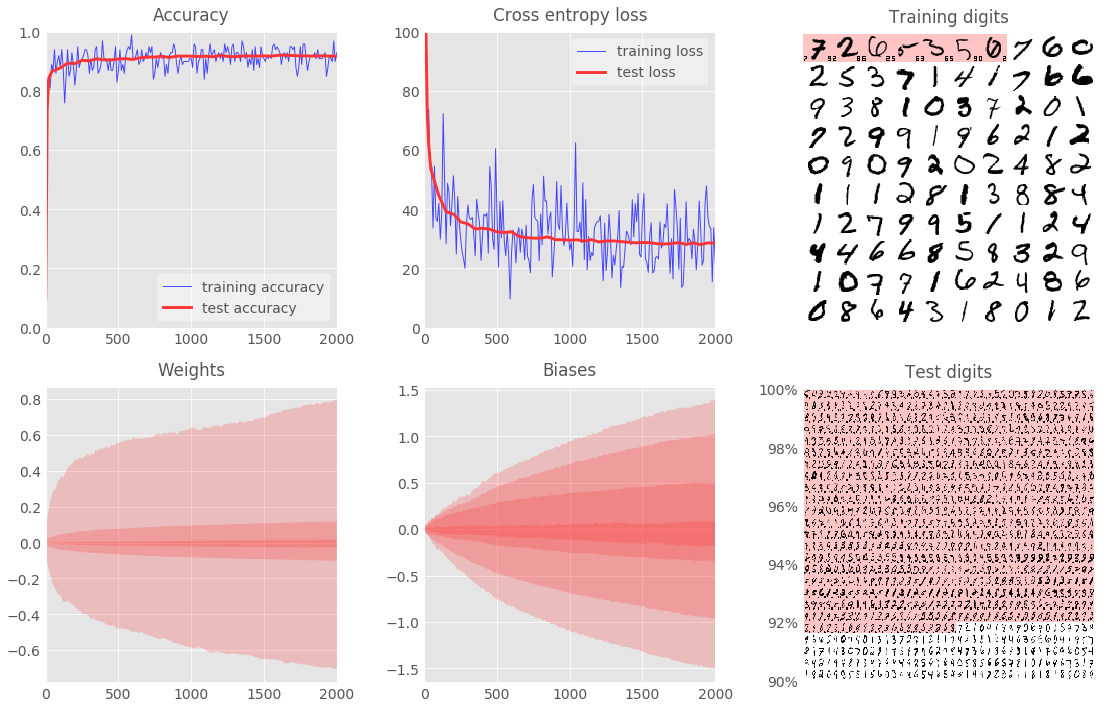

test accuracy: 0.9213


In [2]:

#model
Y = tf.nn.softmax(tf.matmul(tf.reshape(X,[-1, 784]), W) + b)
#placeholder for correct labels
Y_ = tf.placeholder(tf.float32, [None, 10])

#loss function that needs to be minimized
cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y))*1000.0

# % of correct answers found in batch
is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

#optimizer
optimizer = tf.train.GradientDescentOptimizer(0.003)
train_step = optimizer.minimize(cross_entropy)


# matplotlib visualisation
allweights = tf.reshape(W, [-1])
allbiases = tf.reshape(b, [-1])
I = tensorflowvisu.tf_format_mnist_images(X, Y, Y_)  # assembles 10x10 images by default
It = tensorflowvisu.tf_format_mnist_images(X, Y, Y_, 1000, lines=25)  # 1000 images on 25 lines
datavis = tensorflowvisu.MnistDataVis()


#training
sess = tf.Session()
sess.run(init)

# for i in range(1000):
# 	#load training images and their correct labels
# 	batch_X, batch_Y = mnist.train.next_batch(100)
# 	train_data = {X: batch_X, Y_: batch_Y}

# 	#train
# 	sess.run(train_step, feed_dict = train_data)


# # success ?
# a,c = sess.run([accuracy, cross_entropy], feed_dict=train_data)

# # check on test data
# test_data={X: mnist.test.images, Y_: mnist.test.labels}
# a,c = sess.run([accuracy, cross_entropy], feed=test_data)

# You can call this function in a loop to train the model, 100 images at a time
def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    # compute training values for visualisation
    if update_train_data:
        a, c, im, w, b = sess.run([accuracy, cross_entropy, I, allweights, allbiases], feed_dict={X: batch_X, Y_: batch_Y})
        datavis.append_training_curves_data(i, a, c)
        datavis.append_data_histograms(i, w, b)
        datavis.update_image1(im)
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))

    # compute test values for visualisation
    if update_test_data:
        a, c, im = sess.run([accuracy, cross_entropy, It], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        datavis.append_test_curves_data(i, a, c)
        datavis.update_image2(im)
        print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})

#animation
datavis.animate(training_step, iterations=2000+1, train_data_update_freq=10, test_data_update_freq=50, more_tests_at_start=True)

print("test accuracy: " + str(datavis.get_max_test_accuracy()))



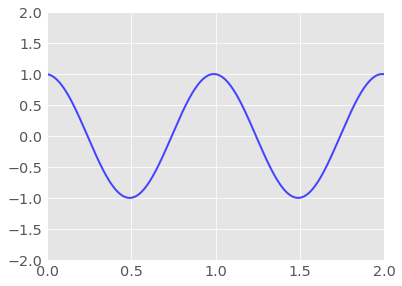

In [3]:
#%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.cos(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

HTML(anim.to_html5_video())

## Conclusion

---

## Acknowledgements

---